In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

dataset_path = "../dataset"
preprocessed_dataset_path = "../dataset/preprocessed_dataset"
codes_path = '../../codes/'
from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
import tqdm
import re
%matplotlib inline

In [2]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

PRS_imputed_Grove = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_nodups_euro_batch2_imputed.gwas.all_score',column_prefix='ASD_imputed_PRS_')

european_volumetric_dataset_term = european_volumetric_dataset_term.merge(PRS_imputed_Grove,on='ID')

In [3]:
available_dwi = pd.read_csv('../../codes/FBA/subject_lists/available_dwi.txt',header=None,names=['ID','Session'])
available_dwi['ID/Ses'] = available_dwi['ID']+'/'+available_dwi['Session'].astype('str')

def concat_files(files):
    to_return = pd.DataFrame()
    for variable,file in files.items():
        temp = pd.read_csv(file,delim_whitespace=True,header=None)
        temp.columns = ['ID/Ses']+[f'wm_{i}_{variable}' for i in range(94,148)]
        temp = temp.drop_duplicates('ID/Ses')
        temp['ID/Ses'] = temp['ID/Ses'].apply(lambda x: x.replace('_','/'))
        temp = temp.set_index('ID/Ses')
        to_return = pd.concat([to_return,temp],axis=1)
    return to_return.reset_index()

tract_metrics = concat_files({'fd':'../../codes/FBA/output_ASD/aba/mean_fd_not_smoothed.txt',
                     'log_fc':'../../codes/FBA/output_ASD/aba/mean_log_fc_not_smoothed.txt',
                     'fdc':'../../codes/FBA/output_ASD/aba/mean_fdc_not_smoothed.txt'})

df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')

df = pd.merge(df,tract_metrics,on=['ID/Ses'],how='inner')

In [4]:
log_fc_res = pd.read_csv('tract_based_mean_log_fc_not_smoothed.csv')
fd_res = pd.read_csv('tract_based_mean_fd_not_smoothed.csv')
fdc_res = pd.read_csv('tract_based_mean_fdc_not_smoothed.csv')

In [111]:

data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()['wm_118']

{'name': 'external capsule left',
 'side': 'left',
 'segment': None,
 'structure': 'external capsule',
 'abbr': 'EC.left'}

fc- 102,103,96
fdc - 102,103, 116, 118

In [53]:
r_squared_dict = defaultdict(dict)
for component in ['wm_102','wm_103','wm_96','wm_116','wm_118']:
    for metric in ['fdc','log_fc']:
        r_squared_dict[component][metric] = []
        for threshold in tqdm.tqdm([i for i in df.columns if 'ASD_imputed_PRS' in i]):
            if metric == 'fd':
                cont_independentVar_cols = [threshold,'GA','PMA']+ancestry
            else:
                cont_independentVar_cols = [threshold,'GA','PMA','TBV']+ancestry
            temp = stats.MassUnivariate.calculate_R_squared_explained(
                df,
                col_to_drop=[threshold],
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=cont_independentVar_cols,
                dependentVar_cols=[f'{component}_{metric}'])
            r_squared_dict[component][metric].append(temp)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 19.86it/s]


In [114]:
log_fc_res.sort

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
0,wm_102_log_fc,0.054573,0.206789,-0.108653,0.095289,0.086585,0.023910,0.016506,0.770810,0.873647,6.398244e-44,0.011049,0.704726,-0.018160,0.531385,0.002595,0.928803,0.119196,0.000052,ASD_imputed_PRS_Pt_0.01
1,wm_102_log_fc,0.051503,0.233001,-0.102542,0.114723,0.073865,0.051859,0.035535,0.527600,0.864536,1.588208e-43,0.013033,0.655522,-0.018645,0.520602,0.010505,0.716795,0.117742,0.000054,ASD_imputed_PRS_Pt_0.05
2,wm_103_log_fc,0.021399,0.609631,-0.042606,0.499372,0.076889,0.038689,0.065471,0.234796,0.841116,1.897372e-43,-0.003575,0.899517,-0.009188,0.744265,-0.003093,0.912668,0.105443,0.000219,ASD_imputed_PRS_Pt_0.01
3,wm_102_log_fc,0.042400,0.333443,-0.084418,0.200269,0.073249,0.058074,0.029903,0.602500,0.857773,3.026267e-42,0.008597,0.771957,-0.026299,0.377002,0.003380,0.909039,0.090276,0.002409,ASD_imputed_PRS_Pt_1
4,wm_115_log_fc,-0.101942,0.179225,0.202966,0.076872,-0.077969,0.238474,-0.216609,0.028230,0.791443,2.353866e-17,-0.019802,0.697645,0.026814,0.598034,-0.037215,0.462924,-0.154783,0.002415,ASD_imputed_PRS_Pt_1e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,wm_136_log_fc,0.043545,0.395532,-0.086698,0.260543,0.114631,0.011854,0.220834,0.001160,0.659383,1.892172e-23,-0.042888,0.216496,0.027416,0.427498,-0.015489,0.654466,-0.000952,0.977880,ASD_imputed_PRS_Pt_1e-08
536,wm_119_log_fc,-0.004522,0.930168,0.009004,0.907856,0.048851,0.279264,0.126583,0.060433,0.756771,1.561389e-28,-0.003679,0.915866,0.006787,0.844610,0.040603,0.240602,0.000191,0.995572,ASD_imputed_PRS_Pt_0.001
537,wm_141_log_fc,0.090116,0.067023,-0.179420,0.015514,0.104967,0.015452,0.211799,0.001115,0.686294,1.045199e-26,-0.011887,0.720198,0.014242,0.669212,0.016529,0.617357,0.000052,0.998748,ASD_imputed_PRS_Pt_0.5
538,wm_109_log_fc,0.024352,0.666122,-0.048485,0.568822,0.200896,0.000064,-0.080653,0.272571,0.835157,6.508797e-29,-0.014367,0.705995,0.027777,0.463416,-0.023265,0.538108,0.000057,0.998789,ASD_imputed_PRS_Pt_0.001


In [119]:
2.19e-4

0.000219

In [124]:
2.19*pow(10,-4)

0.000219

In [117]:
0.000219

0.000219

In [100]:
all_tracts = pd.DataFrame()
for component in ['wm_102','wm_103','wm_96','wm_116','wm_118']:
    temp_tract = pd.DataFrame(r_squared_dict[component])
    temp_tract['tract'] = component
    temp_tract['threshold'] = [i for i in df.columns if 'ASD_imputed_PRS' in i]
    all_tracts = pd.concat([all_tracts,temp_tract],axis=0)

In [80]:
prs_pval = pd.concat([log_fc_res[['Connection','PRS_coef','PRS_pval','threshold']],
          fdc_res[['Connection','PRS_coef','PRS_pval','threshold']]])

In [98]:
temp_prs_pval = prs_pval[prs_pval.Connection.isin([f'{i}_log_fc' for i in ['wm_102','wm_103','wm_96','wm_116','wm_118']]
                                        +[f'{i}_fdc' for i in ['wm_102','wm_103','wm_96','wm_116','wm_118']])].copy()
temp_prs_pval['tract'] = temp_prs_pval.Connection.apply(lambda x: re.findall('wm_\d+',x)[0])
temp_prs_pval['type'] = temp_prs_pval.Connection.apply(lambda x: '_'.join(x.split('_')[2:]))

In [125]:
r2_temp_prs_pval = pd.merge(all_tracts[['log_fc','tract','threshold']],
        temp_prs_pval[temp_prs_pval['type']=='log_fc'],on=['tract','threshold'])

In [126]:
r2_temp_prs_pval.sort_values(by='log_fc',ascending=False)

,log_fc,tract,threshold,Connection,PRS_coef,PRS_pval,type
5,0.013577,wm_102,ASD_imputed_PRS_Pt_0.01,wm_102_log_fc,0.119196,0.000052,log_fc
6,0.013529,wm_102,ASD_imputed_PRS_Pt_0.05,wm_102_log_fc,0.117742,0.000054,log_fc
15,0.010624,wm_103,ASD_imputed_PRS_Pt_0.01,wm_103_log_fc,0.105443,0.000219,log_fc
25,0.007908,wm_96,ASD_imputed_PRS_Pt_0.01,wm_96_log_fc,0.090973,0.013155,log_fc
9,0.007772,wm_102,ASD_imputed_PRS_Pt_1,wm_102_log_fc,0.090276,0.002409,log_fc
8,0.007371,wm_102,ASD_imputed_PRS_Pt_0.5,wm_102_log_fc,0.087784,0.003143,log_fc
7,0.007363,wm_102,ASD_imputed_PRS_Pt_0.1,wm_102_log_fc,0.087319,0.003160,log_fc
16,0.006640,wm_103,ASD_imputed_PRS_Pt_0.05,wm_103_log_fc,0.082487,0.003682,log_fc
26,0.006468,wm_96,ASD_imputed_PRS_Pt_0.05,wm_96_log_fc,0.081413,0.025128,log_fc
45,0.005975,wm_118,ASD_imputed_PRS_Pt_0.01,wm_118_log_fc,0.079075,0.025023,log_fc


In [46]:
log_fc_res[(log_fc_res['Connection']=='wm_116_log_fc') & (log_fc_res['PRS_pval']<0.05)]

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
10,wm_116_log_fc,0.019890,0.603741,-0.039600,0.491634,0.041440,0.218936,-0.013354,0.790047,0.923605,2.140819e-54,0.005091,0.844385,-0.019061,0.464673,0.003037,0.906507,0.071489,0.005849,ASD_imputed_PRS_Pt_0.5
11,wm_116_log_fc,0.019978,0.602201,-0.039776,0.489792,0.042419,0.208671,-0.015079,0.764013,0.925029,1.830647e-54,0.005393,0.835415,-0.018331,0.481458,0.002218,0.931711,0.071212,0.006122,ASD_imputed_PRS_Pt_1


In [50]:
fdc_res[(fdc_res['Connection']=='wm_118_fdc') & (fdc_res['PRS_pval']<0.05)]

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
0,wm_118_fdc,0.027502,0.665543,-0.054757,0.567392,0.110097,0.051053,0.326824,0.000121,0.454786,1.879889e-09,-0.005697,0.894550,-0.049429,0.248387,0.002038,0.962041,0.122861,0.004297,ASD_imputed_PRS_Pt_0.01
6,wm_118_fdc,0.023114,0.717486,-0.046021,0.631895,0.095783,0.088484,0.348213,0.000042,0.443803,4.489114e-09,-0.005613,0.896807,-0.049291,0.252203,0.010454,0.807492,0.104412,0.014443,ASD_imputed_PRS_Pt_0.05
11,wm_118_fdc,0.018032,0.777779,-0.035902,0.708432,0.096631,0.086279,0.347797,0.000044,0.440784,5.704101e-09,-0.006737,0.876373,-0.055573,0.199447,0.002761,0.948965,0.100194,0.019626,ASD_imputed_PRS_Pt_0.1
18,wm_118_fdc,0.014939,0.815353,-0.029744,0.756955,0.096559,0.086990,0.340152,0.000069,0.438539,6.926469e-09,-0.007978,0.853925,-0.058143,0.181743,0.002607,0.951899,0.095472,0.027232,ASD_imputed_PRS_Pt_1
29,wm_118_fdc,0.014859,0.816513,-0.029585,0.758461,0.094893,0.092668,0.343323,0.000059,0.436495,8.239199e-09,-0.008861,0.838070,-0.058413,0.180741,0.004135,0.923782,0.090912,0.035321,ASD_imputed_PRS_Pt_0.5


In [45]:
fdc_res[fdc_res['PRS_pval']<0.05].groupby('Connection').head(4).sort_values(by='Connection')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
9,wm_100_fdc,0.015504,0.802583,-0.030868,0.741263,-0.095121,0.080218,0.533123,2.951896e-10,0.353840,1.064951e-06,0.011293,0.787280,-0.091896,0.028073,0.023485,0.571668,-0.098707,0.017623,ASD_imputed_PRS_Pt_0.001
34,wm_102_fdc,0.118501,0.065297,-0.235935,0.014870,0.097920,0.082767,0.437328,4.192983e-07,0.325907,1.202592e-05,0.042042,0.332720,-0.062962,0.149220,-0.007050,0.870415,0.086342,0.045502,ASD_imputed_PRS_Pt_0.5
33,wm_102_fdc,0.127706,0.047522,-0.254262,0.008972,0.107256,0.059389,0.429249,7.441991e-07,0.338396,6.254582e-06,0.042230,0.330440,-0.053473,0.215741,-0.006684,0.876999,0.087823,0.041983,ASD_imputed_PRS_Pt_0.01
3,wm_102_fdc,0.127009,0.047300,-0.252873,0.008856,0.099421,0.076460,0.441004,2.739522e-07,0.333716,6.912557e-06,0.046196,0.285337,-0.054646,0.203447,-0.001192,0.977793,0.108407,0.010964,ASD_imputed_PRS_Pt_0.05
8,wm_102_fdc,0.121682,0.057507,-0.242268,0.012104,0.100135,0.075094,0.440803,2.931510e-07,0.330444,8.621461e-06,0.044807,0.300658,-0.060962,0.158774,-0.008991,0.834641,0.101998,0.017380,ASD_imputed_PRS_Pt_0.1
26,wm_103_fdc,0.140297,0.022862,-0.279330,0.002720,0.101417,0.061979,0.438324,1.362039e-07,0.358832,6.093897e-07,0.018661,0.652249,-0.050029,0.225271,-0.026962,0.513526,0.088623,0.031771,ASD_imputed_PRS_Pt_0.01
32,wm_103_fdc,0.131033,0.033240,-0.260885,0.004945,0.091768,0.088944,0.447029,7.117733e-08,0.346142,1.309552e-06,0.018163,0.661281,-0.059148,0.156344,-0.027055,0.512759,0.083949,0.041968,ASD_imputed_PRS_Pt_0.5
19,wm_103_fdc,0.133915,0.029334,-0.266624,0.004034,0.093213,0.083672,0.451380,4.823128e-08,0.349971,9.885761e-07,0.019912,0.630811,-0.056327,0.174045,-0.028143,0.495419,0.090580,0.027324,ASD_imputed_PRS_Pt_0.1
7,wm_103_fdc,0.138704,0.023952,-0.276158,0.002915,0.092637,0.084841,0.451474,4.508950e-08,0.352954,7.862970e-07,0.021240,0.607776,-0.050750,0.217610,-0.021229,0.604832,0.097085,0.017309,ASD_imputed_PRS_Pt_0.05
30,wm_107_fdc,-0.047550,0.574162,0.094673,0.458102,0.026583,0.719114,0.222398,4.428600e-02,0.380318,1.023771e-04,-0.063785,0.264529,0.019616,0.729655,-0.005707,0.919720,-0.119077,0.035554,ASD_imputed_PRS_Pt_0.001


In [5]:
log_fc_res_best = log_fc_res[(log_fc_res['threshold'] == 'ASD_imputed_PRS_Pt_0.01') & (log_fc_res['PRS_pval']<0.05/6)].copy()
log_fc_res_best['tract'] = log_fc_res_best['Connection'].apply(lambda x: data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()[x.replace('_log_fc','')]['abbr'])

In [6]:
r_squared_dict = defaultdict(dict)
for component in ['wm_102','wm_103']:
    for metric in ['fdc','fd','log_fc']:
        r_squared_dict[component][metric] = []
        for threshold in tqdm.tqdm([i for i in df.columns if 'ASD_imputed_PRS' in i]):
            if metric == 'fd':
                cont_independentVar_cols = [threshold,'GA','PMA']+ancestry
            else:
                cont_independentVar_cols = [threshold,'GA','PMA','TBV']+ancestry
            temp = stats.MassUnivariate.calculate_R_squared_explained(
                df,
                col_to_drop=[threshold],
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=cont_independentVar_cols,
                dependentVar_cols=[f'{component}_{metric}'])
            r_squared_dict[component][metric].append(temp)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 22.65it/s]


In [7]:
r_squared_df = pd.DataFrame()
for name,component in zip(['SCR.L','SCR.R'],['wm_102','wm_103']):
    for metric in ['fd','log_fc','fdc']:
        temp = pd.DataFrame({'R2':r_squared_dict[component][metric]})
        temp['tract'] = name
        temp['type'] = metric
        temp['thresholds'] = [i.split('_')[-1] for i in df.columns if 'ASD_imputed_PRS' in i]
        r_squared_df = pd.concat([r_squared_df,temp])

In [8]:
prs_val_df = pd.concat([log_fc_res[['Connection','threshold','PRS_pval']],
           fdc_res[['Connection','threshold','PRS_pval']],
           fd_res[['Connection','threshold','PRS_pval']]])

prs_val_df = prs_val_df[prs_val_df['Connection'].isin([f'{i}_{metric}' for metric in ['fd','fdc','log_fc'] for i in ['wm_102','wm_103']])].copy()

prs_val_df['threshold'] = prs_val_df['threshold'].apply(lambda x: x.split('_')[-1])
prs_val_df['type'] = prs_val_df['Connection'].apply(lambda x: '_'.join(x.split('_')[-2:]) if 'log' in x else x.split('_')[-1])
prs_val_df['tract'] = prs_val_df['Connection'].apply(lambda x: 'SCR.R' if '_'.join(x.split('_')[0:2]) == 'wm_103' else 'SCR.L')
prs_val_df = prs_val_df.rename(columns={'threshold':'thresholds'})

In [9]:
r_squared_df = prs_val_df.merge(r_squared_df,on=['thresholds','type','tract']).sort_values(by='PRS_pval')
r_squared_df['significance'] = r_squared_df['PRS_pval'].apply(lambda x: '**' if x<0.05/6/54/2 else '*' if x<0.05 else '')

In [10]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['ASD_imputed_PRS_Pt_0.01','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[f'wm_{i}_log_fc' for i in range(94,148)])

to_plot_values = {int(k.replace('wm_','').replace('_log_fc','')):1-v for k,v in zip(mass_univariate.index.tolist(),mass_univariate["standardize(Q('ASD_imputed_PRS_Pt_0.01'))_pval"].values)}

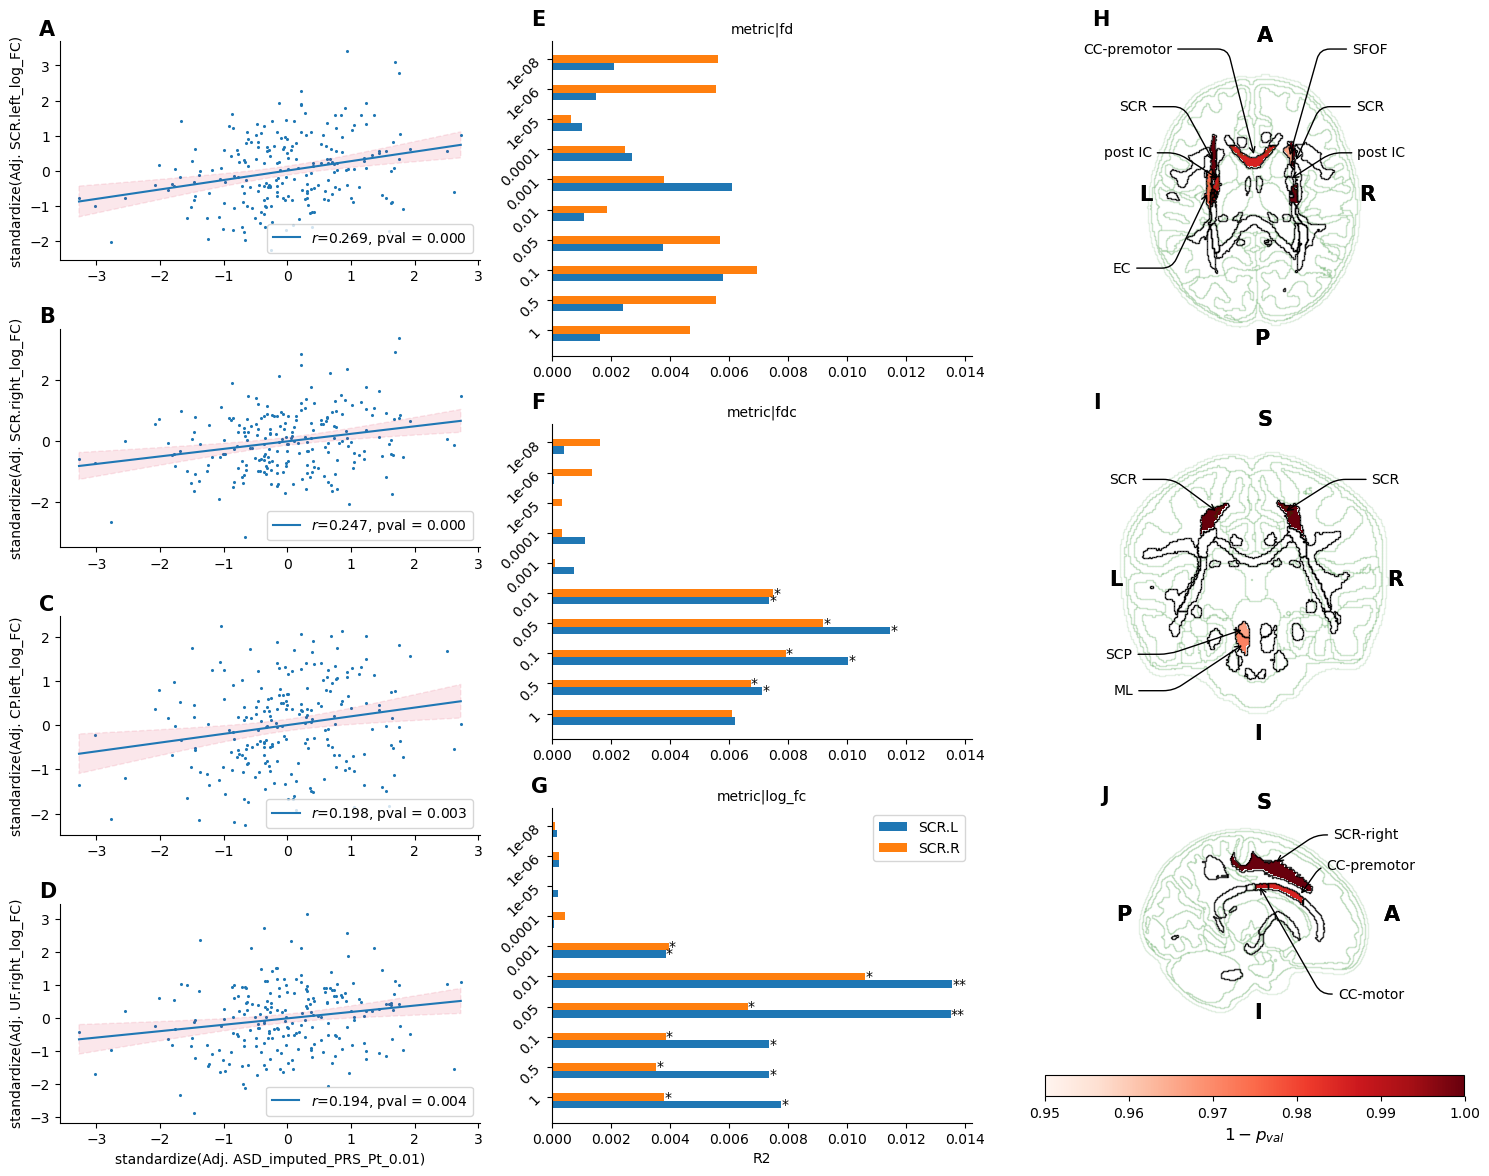

In [12]:
fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(12,3)
axes1 = fig.add_subplot(gs[0:3, 0])
axes2 = fig.add_subplot(gs[3:6, 0])
axes3 = fig.add_subplot(gs[6:9, 0])
axes4 = fig.add_subplot(gs[9:12, 0])

axes1.get_shared_x_axes().join(axes1, axes2, axes3, axes4)


axes5 = fig.add_subplot(gs[0:4, 1])
axes6 = fig.add_subplot(gs[4:8, 1])
axes7 = fig.add_subplot(gs[8:12, 1])

for ax in [axes6,axes7]:
    ax.sharey(axes5)
    ax.sharex(axes5)


axes8 = fig.add_subplot(gs[0:4, 2])
axes9 = fig.add_subplot(gs[4:8, 2])
axes10 = fig.add_subplot(gs[8:12, 2])

for idx,(ax,connection,name) in enumerate(zip([axes1,axes2,axes3,axes4],['wm_102_log_fc','wm_103_log_fc','wm_124_log_fc','wm_140_log_fc'],
                             ['SCR.left','SCR.right','CP.left','UF.right'])):
    visualisation.SimplePlots.Scatter(y=connection,
                                      x='ASD_imputed_PRS_Pt_0.01',
                                      data=df,
                                      adjust_covar={'y':['sex','GA','PMA','TBV'],
                                                   'x':ancestry},ax=ax,fig=fig,legend_loc='lower right',
                                     ylabel=f'{name}_log_FC')
    if idx<3:
        ax.set_xlabel('')
sns.despine()

visualisation.SimplePlots.Bar(
    x='thresholds',
    y='R2',
    hue='tract',
    data=r_squared_df,
    separateby='type',
    annotate='significance',
    order={'hue':['SCR.L','SCR.R'],'x':[i.split('_')[-1] for i in df.columns if 'ASD_imputed_PRS' in i][::-1]},
    figsize=(15,5),
    barwidth=0.5,
    ylabel_pos=(-.015,.6),
    ylabel='',
    plot_label='metric',
    xlabel='',
    fig=fig,ax=np.array([axes5,axes6,axes7]),orientation='horizontal',rotation_x=90,legend_loc='upper right')

axes7.set_xlabel('R2')

for idx,ax in enumerate([axes5,axes6,axes7]):
    ax.tick_params(axis='y',rotation=45)
    
atlas_slice=120
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=np.array([axes8,axes9,axes10]))
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=np.array([axes8,axes9,axes10]),fig=fig,colorbar=True,cb_vmin=0.95,cb_vmax=1)

############################################

axes8.annotate('CC-premotor',
            xy=(100, 100), xycoords='data',
            xytext=(-10, 10), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=100,rad=10"),
            horizontalalignment='center')
axes8.annotate('SCR',
            xy=(65, 105), xycoords='data',
            xytext=(-5, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('SCR',
            xy=(135, 105), xycoords='data',
            xytext=(200, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('post IC',
            xy=(70, 120), xycoords='data',
            xytext=(-10, 100), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')
axes8.annotate('post IC',
            xy=(130, 120), xycoords='data',
            xytext=(210, 100), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes8.annotate('EC',
            xy=(60, 130), xycoords='data',
            xytext=(-15, 200), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes8.annotate('SFOF',
            xy=(130, 101), xycoords='data',
            xytext=(200, 10), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

################################################

axes9.annotate('SCR',
            xy=(75, 60), xycoords='data',
            xytext=(10, 40), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('SCR',
            xy=(120, 60), xycoords='data',
            xytext=(190, 40), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('ML',
            xy=(93, 150), xycoords='data',
            xytext=(10, 185), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes9.annotate('SCP',
            xy=(93, 140), xycoords='data',
            xytext=(7, 160), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=0,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('SCR-right',
            xy=(155, 54), xycoords='data',
            xytext=(245, 30), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('CC-premotor',
            xy=(180, 86), xycoords='data',
            xytext=(250, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

axes10.annotate('CC-motor',
            xy=(140, 75), xycoords='data',
            xytext=(250, 186), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')
################################################

for ax, number in zip([axes1,axes2,axes3,axes4,axes5,axes6,axes7],['A','B','C','D','E','F','G']):
    ax.text(-0.05, 1.1, number, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top')

axes8.text(-0.2,1.1,'H',transform=axes8.transAxes,fontsize=15,fontweight='bold',va='top')
axes9.text(-0.05,1.1,'I',transform=axes9.transAxes,fontsize=15,fontweight='bold',va='top')
axes10.text(-0.05,1.1,'J',transform=axes10.transAxes,fontsize=15,fontweight='bold',va='top')

plt.tight_layout()
fig.savefig('test.png')

A-D Scatter plots of association between mean log FC of 4 tracts and ASD-PRS at Pt 0.01. E-G Bar plots of R-squared explained by PRS across different Pt. * p < 0.05 ** p < 7.7e-5 . H-J Visual representation of tracts with mean log FC associated with ASD-PRS at Pt 0.01. (CC- corpus callosum, SCR- superior corona radiata, SFOF – Superior fronto-occipital fasciculus, post IC – posterior internal capsule, EC – external capsule, ML – medial lemnicus, SCP – superior cerebral peduncle 

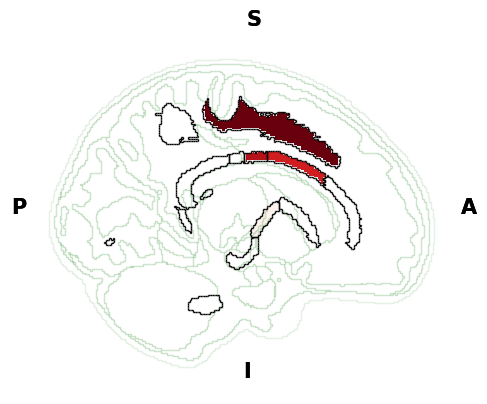

In [221]:
fig,ax = plt.subplots(1,1)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],map_view=['sagittal'],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=ax)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,map_view=['sagittal'],
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=ax,fig=fig,colorbar=False,cb_vmin=0.95,cb_vmax=1)

Text(250, 186, 'CC-motor')

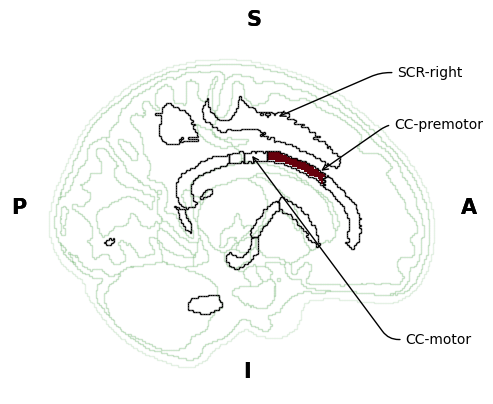

In [254]:
fig,ax = plt.subplots(1,1)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],map_view=['sagittal'],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=ax)
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values={144:1},map_view=['sagittal'],
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=ax,fig=fig,colorbar=False,cb_vmin=0.95,cb_vmax=1)

ax.annotate('SCR-right',
            xy=(155, 54), xycoords='data',
            xytext=(245, 30), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

ax.annotate('CC-premotor',
            xy=(180, 86), xycoords='data',
            xytext=(250, 60), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

ax.annotate('CC-motor',
            xy=(140, 75), xycoords='data',
            xytext=(250, 186), textcoords='data',
            arrowprops=dict(arrowstyle="->",facecolor='black',connectionstyle="arc,angleA=180,armA=50,rad=10"),
            horizontalalignment='center')

In [168]:
{data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()[f'wm_{k}']['abbr']:(v,k) for k,v in to_plot_values.items() if v > 0.95}

{'IC.left.posterior': (0.9876013937804962, 96),
 'IC.right.posterior': (0.9508115508876271, 97),
 'SCR.left': (0.9999404380456216, 102),
 'SCR.right': (0.9997778608652838, 103),
 'EC.left': (0.9751382738771438, 118),
 'CP.left': (0.9970433645716436, 124),
 'SFOF.right': (0.9658738663626196, 127),
 'SCP.left': (0.9663995882986438, 132),
 'ICP.left': (0.9751326307360001, 136),
 'UF.right': (0.9961501946672568, 140),
 'ML.left': (0.9718495086821003, 141),
 'CC2': (0.9864608126201545, 144),
 'CC3': (0.9911114364322541, 145)}

In [103]:
data_preprocessing.Diffusion.WM_parcellation.get_wm_parcellation()['wm_94']

{'name': 'anterior limb of internal capsule left',
 'side': 'left',
 'segment': 'anterior',
 'structure': 'internal capsule',
 'abbr': 'IC.left.anterior'}

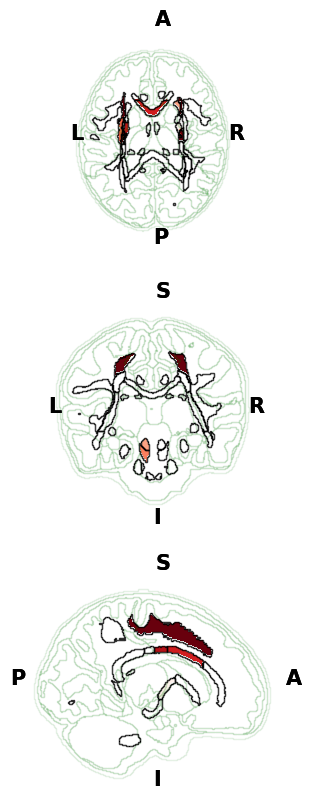

In [36]:
fig,axes=plt.subplots(3,1,figsize=(15,10))
axes = axes.flatten()
atlas_slice=120
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-dHCP-structure-parcellation.nii.gz',
    regions_to_hide=[i for i in range(88)],
    atlas_slice=atlas_slice,
    outline_alpha=0.1,
    outline_colour='green',
    axes=axes[0:3])
_,_ = visualisation.Brainmap.plot_segmentation(
    atlas_file='../../dataset/visualise/wm_parcellation/parcellation_maps_05mm/reference-05mm-WM-parcellation.nii.gz',
    plot_values=to_plot_values,
    atlas_slice=atlas_slice,
    plot_values_threshold=0.95,
    cb_title='$1-p_{val}$',
    cb_orientation='horizontal',
    cmap='Reds',
    axes=axes[0:3],fig=fig,colorbar=False,cb_vmin=0.95,cb_vmax=1)


In [34]:
to_plot_values

{94: 0.347295354190469,
 95: 0.6322438432907991,
 96: 0.9876013937804962,
 97: 0.9508115508876271,
 98: 0.11563778773758471,
 99: 0.32075489310145167,
 100: 0.3720881300323722,
 101: 0.060232969628312594,
 102: 0.9999404380456216,
 103: 0.9997778608652838,
 104: 0.22601547028209967,
 105: 0.44095397680211534,
 106: 0.9109113394596683,
 107: 0.4838528929798952,
 108: 0.6858932419816932,
 109: 0.9181357069064938,
 110: 0.8756744462356424,
 111: 0.8309735130699217,
 112: 0.1885470996074161,
 113: 0.11819326288985921,
 114: 0.03307334873258272,
 115: 0.44955370016009377,
 116: 0.7911919861150698,
 117: 0.1463337355924168,
 118: 0.9751382738771438,
 119: 0.8814845285084474,
 120: 0.31029670986861124,
 121: 0.3017324001188648,
 122: 0.10065911402993111,
 123: 0.9190907393209354,
 124: 0.9970433645716436,
 125: 0.8058348597137108,
 126: 0.905382119033793,
 127: 0.9658738663626196,
 128: 0.38988204329837006,
 129: 0.6930871746842299,
 130: 0.9251267585419404,
 131: 0.5459492676487484,
 132: 0.

In [47]:
np.concatenate([axes5,axes6])

ValueError: zero-dimensional arrays cannot be concatenated

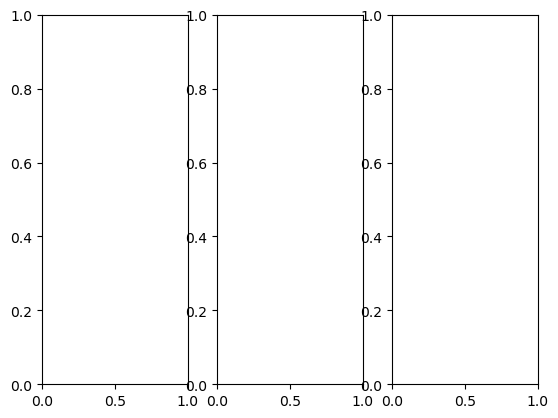

In [53]:
fig,axes = plt.subplots(1,3)

In [57]:
np.array([axes1,axes2,axes3])

array([<AxesSubplot:ylabel='standardize(Adj. SCR.left_log_FC)'>,
       <AxesSubplot:ylabel='standardize(Adj. SCR.right_log_FC)'>,
       <AxesSubplot:ylabel='standardize(Adj. CP.left_log_FC)'>],
      dtype=object)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [58]:
axes

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

<AxesSubplot:xlabel='standardize(Adj. ASD_PRS_Pt_0.01)', ylabel='standardize(Adj. log_FC_mean_significant_fixels)'>

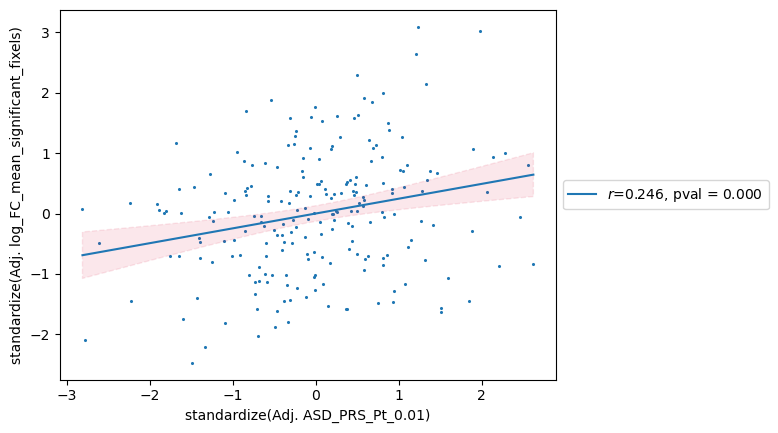

In [67]:
visualisation.SimplePlots.Scatter(y='log_FC_mean_significant_fixels',x='ASD_PRS_Pt_0.01',data=df,
                                 adjust_covar={'y':['TBV','GA','PMA','sex'],'x':ancestry})

In [61]:
df = pd.concat([df,log_fc_mean_L_R],axis=1)

In [58]:
log_fc_mean_L_R.columns = ['log_FC_mean_significant_fixels']

In [55]:
log_fc_mean_L_R = pd.read_csv('../../codes/FBA/output_ASD/tractography/individual_tracts/cst_L_R/mean-log_fc-cst_L_R-significant.txt',header=None)

In [ ]:
visualisation.SimplePlots.Scatter(y='mean_',x='ASD_PRS_Pt_0.01',data=df,
                                 adjust_covar={'y':['TBV','GA','PMA','sex'],'x':ancestry})

In [51]:
0.05/6

0.008333333333333333

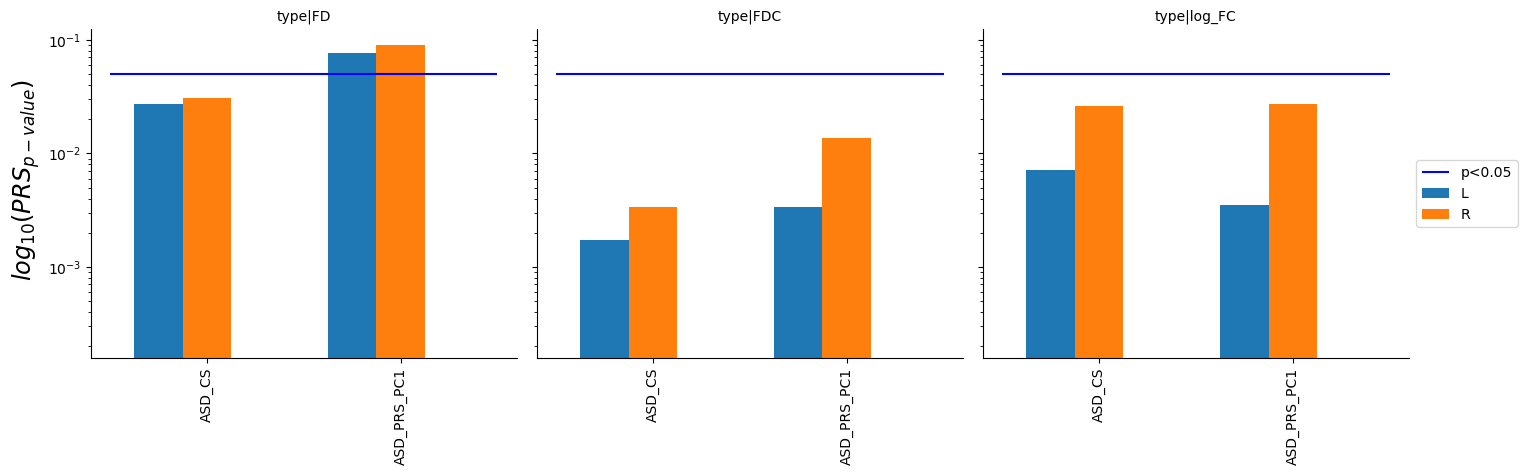

In [17]:
visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Tract',data=to_plot,
                          separateby='type',
                         order={
                               'hue':['L','R']},yscalelog=True,
                         ylabel='$log_{10}(PRS_{p-value})$',rotation_x=90,
                              hline=[0.05],hline_label=['p<0.05'],
                         figsize=(15,5),barwidth=0.5,xlabel=None,ylabel_pos=(-.015,.6))
plt.tight_layout()
sns.despine()

In [15]:
to_plot = pd.concat([test[['Connection','PRS_pval','threshold']],
          test2[['Connection','PRS_pval','threshold']]]).copy()

to_plot = to_plot[to_plot['threshold'].isin([i for i in df.columns if 'ASD_CS' in i or 'ASD_PRS_PC1' in i])].copy()

# to_plot = pd.concat([test[['Connection','PRS_pval','threshold']],
#           test2[['Connection','PRS_pval','threshold']]]).copy()
# to_plot = test[['Connection','PRS_pval','threshold']].copy()
to_plot['type'] = to_plot['Connection'].apply(lambda x: x.split('_mean')[0])

to_plot['Tract'] = to_plot['Connection'].apply(lambda x: '+'.join(x.split('_mean')[1].split('_')[1:]))

# visualisation.SimplePlots.Bar(x='threshold',y='PRS_pval',hue='Connection',data=to_plot[to_plot['type']=='log_FC'],
#                               order={'x':[i for i in tract_volumes.columns if 'ASD_PRS' in i]},
#                               yscalelog=True,hline=0.05,rotation_x=90)

In [50]:
visualisation.SimplePlots.Groupby.groupby(separateby,x,hue,y=y,colorby=colorby,y2=y2)

TypeError: unhashable type: 'numpy.ndarray'

In [59]:
args = groupby(separateby,x,hue,y=y)

In [58]:
def groupby(*args,**kwargs):
    args = [list(chain.from_iterable(i)) for i in args if i is not None]
    kwargs = {k:v for k,v in kwargs.items() if v is not None}
    all_unique_keys = [tuple(set(i)) for i in args]
    all_possible_keys = product(*all_unique_keys)
    all_values = list(kwargs.keys())

    return all_possible_keys

In [13]:
def dictionary_merge(dict1,dict2):
#convenience function to merge nested dictionary together
    for key in dict2:
        if key in dict1:
            if isinstance(dict1[key],dict) and isinstance(dict2[key],dict):
                dictionary_merge(dict1[key],dict2[key])
        else:
            dict1[key]=dict2[key]
    return dict1

In [54]:
from itertools import chain,product

In [11]:
y2=[0 for i in range(len(x))]

In [9]:
x,y,colorby,separateby,hue = visualisation.SimplePlots.Bar(x='thresholds',y='R2',hue='tract',data=r_squared_df,separateby='type')

In [116]:
{k:v for k,v in to_plot_values.items() if v > 0.95}

{96: 0.9876013937804962,
 97: 0.9508115508876271,
 102: 0.9999404380456216,
 103: 0.9997778608652838,
 118: 0.9751382738771438,
 124: 0.9970433645716436,
 127: 0.9658738663626196,
 132: 0.9663995882986438,
 136: 0.9751326307360001,
 140: 0.9961501946672568,
 141: 0.9718495086821003,
 144: 0.9864608126201545,
 145: 0.9911114364322541}

In [25]:
log_fc_res_best

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,...,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold,tract
0,wm_102_log_fc,0.055408,0.201444,-0.110316,0.091429,0.085344,0.026468,0.027783,0.625102,0.864737,...,0.010341,0.723728,-0.019254,0.508398,0.003394,0.907277,0.118679,0.000060,ASD_imputed_PRS_Pt_0.01,SCR.left
2,wm_103_log_fc,0.023166,0.582205,-0.046124,0.466739,0.076855,0.039679,0.078142,0.158392,0.830371,...,-0.003253,0.908947,-0.009597,0.734501,-0.002124,0.940255,0.105821,0.000222,ASD_imputed_PRS_Pt_0.01,SCR.right
5,wm_124_log_fc,0.070584,0.155942,-0.140531,0.060914,0.129679,0.003403,0.161081,0.014116,0.704243,...,0.018247,0.586467,-0.009139,0.784134,-0.020906,0.531659,0.099859,0.002957,ASD_imputed_PRS_Pt_0.01,CP.left
9,wm_140_log_fc,-0.039773,0.486419,0.079187,0.357268,-0.070269,0.164531,-0.080373,0.284468,0.891999,...,-0.015186,0.693968,-0.019638,0.609065,-0.041692,0.278832,0.111679,0.003850,ASD_imputed_PRS_Pt_0.01,UF.right


In [22]:
log_fc_res[log_fc_res['threshold']=='ASD_imputed_PRS_Pt_0.01']

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
0,wm_102_log_fc,0.055408,0.201444,-0.110316,0.091429,0.085344,0.026468,0.027783,6.251016e-01,0.864737,3.572124e-43,0.010341,0.723728,-0.019254,0.508398,0.003394,0.907277,0.118679,0.000060,ASD_imputed_PRS_Pt_0.01
2,wm_103_log_fc,0.023166,0.582205,-0.046124,0.466739,0.076855,0.039679,0.078142,1.583919e-01,0.830371,1.709630e-42,-0.003253,0.908947,-0.009597,0.734501,-0.002124,0.940255,0.105821,0.000222,ASD_imputed_PRS_Pt_0.01
5,wm_124_log_fc,0.070584,0.155942,-0.140531,0.060914,0.129679,0.003403,0.161081,1.411629e-02,0.704243,4.076419e-27,0.018247,0.586467,-0.009139,0.784134,-0.020906,0.531659,0.099859,0.002957,ASD_imputed_PRS_Pt_0.01
9,wm_140_log_fc,-0.039773,0.486419,0.079187,0.357268,-0.070269,0.164531,-0.080373,2.844681e-01,0.891999,4.402888e-31,-0.015186,0.693968,-0.019638,0.609065,-0.041692,0.278832,0.111679,0.003850,ASD_imputed_PRS_Pt_0.01
12,wm_145_log_fc,-0.006132,0.915913,0.012209,0.888891,-0.005217,0.918987,-0.019058,8.026749e-01,0.838529,8.430270e-28,0.027746,0.479802,0.017026,0.662819,-0.043707,0.264306,0.102625,0.008889,ASD_imputed_PRS_Pt_0.01
14,wm_96_log_fc,0.053970,0.315353,-0.107453,0.184378,0.044165,0.352108,0.425191,6.877725e-09,0.473234,3.926244e-13,0.012813,0.723977,-0.012150,0.736385,-0.021121,0.559105,0.090606,0.012399,ASD_imputed_PRS_Pt_0.01
16,wm_144_log_fc,0.000572,0.993117,-0.001138,0.990892,-0.076058,0.194546,-0.280323,1.453952e-03,0.958408,7.062354e-28,0.003038,0.945899,0.026205,0.556404,-0.023456,0.599067,0.110394,0.013539,ASD_imputed_PRS_Pt_0.01
21,wm_118_log_fc,-0.014320,0.781354,0.028511,0.713440,0.045690,0.316516,0.083949,2.160671e-01,0.785104,5.738290e-30,0.004570,0.895687,-0.007270,0.833938,0.019767,0.569381,0.078002,0.024862,ASD_imputed_PRS_Pt_0.01
22,wm_136_log_fc,0.054887,0.291229,-0.109280,0.162960,0.138164,0.002876,0.195116,4.596692e-03,0.665432,2.409898e-23,-0.038859,0.268838,0.022479,0.519824,-0.023117,0.508695,0.078524,0.024867,ASD_imputed_PRS_Pt_0.01
27,wm_141_log_fc,0.093952,0.060382,-0.187058,0.013238,0.134125,0.002564,0.185393,4.989790e-03,0.689695,3.673539e-26,-0.011052,0.742700,0.008148,0.807762,0.009450,0.778140,0.073684,0.028150,ASD_imputed_PRS_Pt_0.01


In [32]:
!xdg-open test.png

In [16]:
set(product(separateby,x))

TypeError: unhashable type: 'numpy.ndarray'

In [18]:
list(chain.from_iterable(separateby))

['fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'fd',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'log_fc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc',
 'fdc']